<a href="https://colab.research.google.com/github/Cryslender/AI-Exam-machine-learning-/blob/main/AI_Exam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Necessary Modules

In [54]:
!pip install scikeras
!pip install keras-tuner -q
import keras_tuner
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import layers
%matplotlib inline
np.random.seed(0)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#Dataset

In [55]:
#importing MNIST dataset from keras to use it in the program
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print("Training Dataset")
print("X_Training: ", str(x_train.shape))
print("Y_Training: ", str(y_train.shape))
print("\nTesting Dataset")
print("X_Testing: ", str(x_test.shape))
print("Y_Testing: ", str(y_test.shape))

Training Dataset
X_Training:  (60000, 28, 28)
Y_Training:  (60000,)

Testing Dataset
X_Testing:  (10000, 28, 28)
Y_Testing:  (10000,)


#Data Pre-processing

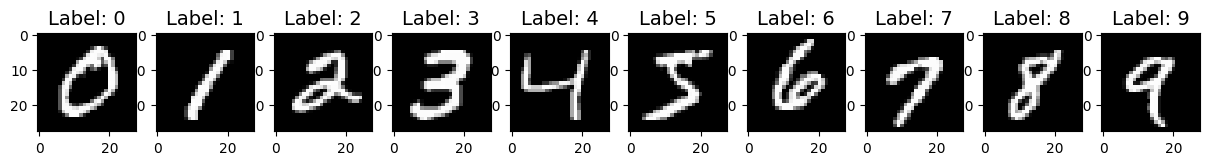

In [56]:
#ploting the dataset
fig,axes = plt.subplots(1, 10, figsize=(15,15))

for i in range(0, 10):
  axes[i].imshow(x_train[y_train == i][0], cmap=plt.get_cmap('gray'))
  axes[i].set_title("Label: {}".format(i), fontsize=14)

In [57]:
# Normalize Data
x_train = x_train / 255.0
x_test = x_test / 255.0
# Reshape Data
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)
print(x_train.shape)

(60000, 784)


In [58]:
#convert the lables into one-hot enconded vector
num_classes=10
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

for i in range(10):
  print(y_train[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]


#Model Design(ANN Model Structure)

In [60]:
#define model to build using dense layers for flatten array of images
def define_model(units, activation, dropout, lr):
    model = keras.Sequential()
    model.add(layers.Flatten())
    model.add(layers.Dense(units=units, activation=activation))
    if dropout:
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation="softmax"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

#Create hyperparameters for the model to use tuner search on
def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh","softmax","segmoid"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = define_model(
        units=units, activation=activation, dropout=dropout, lr=lr
    )
    return model

#Model training and validation

In [61]:
#define tuner class search called Random Search to search randomlly for perfect paramaeters on maximun trial of 3 since the dataset is big
tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=2,
    overwrite=True,
    directory="my_document",
    project_name="AI Exam",
)
tuner.search_space_summary()
tuner.search(x_train, y_train, epochs=2, validation_data=(x_train, y_train))
#model.fit(x_train,y_train, batch_size = 512, epochs=10)

Trial 3 Complete [00h 01m 09s]
val_accuracy: 0.9210166931152344

Best val_accuracy So Far: 0.9836916625499725
Total elapsed time: 00h 03m 18s


In [62]:
tuner.results_summary()

Results summary
Results in my_document/AI Exam
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
units: 320
activation: relu
dropout: False
lr: 0.002030055392371263
Score: 0.9836916625499725

Trial 1 summary
Hyperparameters:
units: 352
activation: tanh
dropout: False
lr: 0.0005057140844109131
Score: 0.9654833376407623

Trial 2 summary
Hyperparameters:
units: 224
activation: tanh
dropout: True
lr: 0.00010469611294992556
Score: 0.9210166931152344


In [66]:
# Get the top 2 hyperparameters.
best_hps = tuner.get_best_hyperparameters(5)
# Build the model with the best hp.
model = build_model(best_hps[0])
# Fit with the entire dataset.
x_all = np.concatenate((x_train, x_test))
y_all = np.concatenate((y_train, y_test))
model.fit(x=x_all, y=y_all, epochs=2)

Epoch 1/2
2188/2188 [==============================] - 10s 4ms/step - loss: 0.1778 - accuracy: 0.9464
Epoch 2/2
2188/2188 [==============================] - 10s 4ms/step - loss: 0.0777 - accuracy: 0.9757


#Model evaluation and testing

In [71]:
#test the model on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print("Test Loss: {}, Test Accuracy: {}".format(test_loss, test_acc))

313/313 [==============================] - 1s 2ms/step - loss: 0.0453 - accuracy: 0.9840
Test Loss: 0.04530545324087143, Test Accuracy: 0.984000027179718


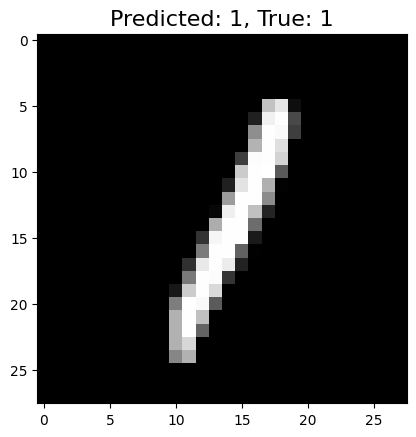

In [69]:
# check if the model predict the exert value
random_idx = np.random.choice(len(x_test))
x_sample = x_test[random_idx]
y_true = np.argmax(y_test, axis=1)
y_sample_true = y_true[random_idx]
y_sample_pred_class = y_pred_classes[random_idx]

plt.title("Predicted: {}, True: {}".format(y_sample_pred_class, y_sample_true), fontsize=16)
plt.imshow(x_sample.reshape(28, 28), cmap='gray')

#Confusion Matrix

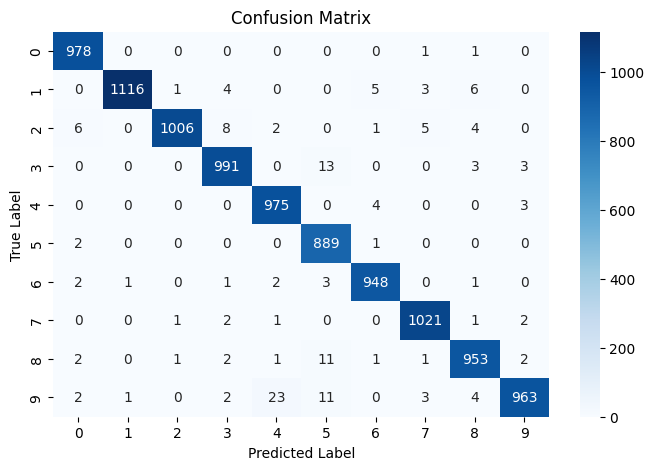

In [70]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)

# Plot
fig, ax = plt.subplots(figsize=(8,5))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('Confusion Matrix');